<a href="https://colab.research.google.com/github/camulro/Aprendizaje-II/blob/sesi%C3%B3n3/rbig_demo_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RBIG Demo

In [1]:
!pip install python-picard
!pip install "git+https://github.com/IPL-UV/rbig.git"

import numpy as np
import warnings
from time import time

# from rbig.model import RBIG
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings('ignore') # get rid of annoying warnings

%matplotlib inline
%load_ext autoreload
%autoreload 2

  Cloning https://github.com/IPL-UV/rbig.git to /tmp/pip-req-build-a764c8m2
  Running command git clone -q https://github.com/IPL-UV/rbig.git /tmp/pip-req-build-a764c8m2
  Created wheel for py-rbig: filename=py_rbig-0.0.1-py3-none-any.whl size=17259 sha256=d4e9aed50d3cccaea61f58cd8ff85ed39272a08645b7a22cf51eafcb530f0109
  Stored in directory: /tmp/pip-ephem-wheel-cache-o47ge5mk/wheels/12/41/57/9fa97cc329c889866c724e8343d727c14192a59114814fdc2d
Successfully built py-rbig


#### Toy Data

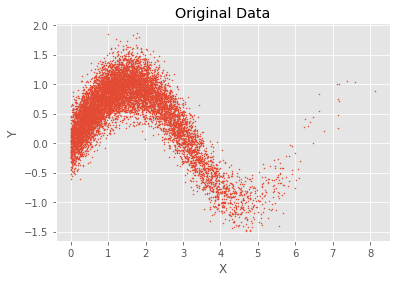

In [2]:
seed = 123
rng = np.random.RandomState(seed=seed)

num_samples = 10000
x = np.abs(2 * rng.randn(1, num_samples))
y = np.sin(x) + 0.25 * rng.randn(1, num_samples)
data = np.vstack((x, y)).T

fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Original Data')
plt.show()

## RBIG Fitting

In [3]:
%%time 
from rbig import RBIG

rotation_type = 'pca'
n_layers = 1000
# Initialize RBIG class

rbig_model = RBIG(rotation = rotation_type, 
                  max_layers = n_layers,)

# transform data
data_trans = rbig_model.fit_transform(data)

Completed! (Total Info Red: 0.7124):   8%|▊         | 77/1000 [00:02<00:24, 38.28it/s]


CPU times: user 3.05 s, sys: 319 ms, total: 3.36 s
Wall time: 4.11 s


In [6]:
rbig_model.info_loss

array([0.39649345, 0.10815173, 0.13063006, 0.03908914, 0.01551918,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01056225, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01195332])

### Transform Data into Gaussian

(10000, 2)


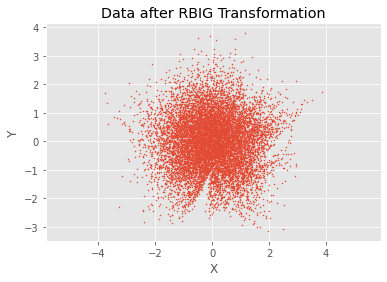

In [7]:
print(data_trans.shape)
fig, ax = plt.subplots()
ax.scatter(data_trans[:, 0], data_trans[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Data after RBIG Transformation')
ax.axis('equal')
plt.show()

### Invertible

In [8]:
%%time
# transform data
data_approx = rbig_model.inverse_transform(data_trans)

# check approximation
np.testing.assert_array_almost_equal(data, data_approx)

CPU times: user 81.3 ms, sys: 426 µs, total: 81.7 ms
Wall time: 81.7 ms


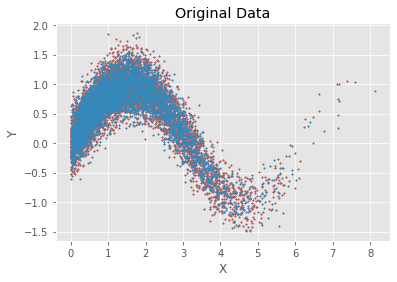

In [9]:
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=2)
ax.scatter(data_approx[:, 0], data_approx[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Original Data')
plt.show()

In [10]:
np.sum(np.abs(data-data_approx))

2.4331253779694357e-08

### Information Reduction

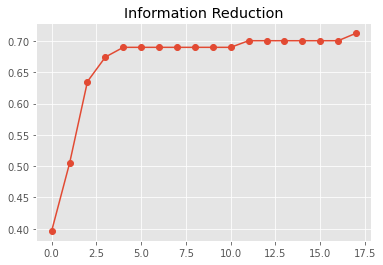

In [11]:

fig, ax = plt.subplots()
ax.plot(np.cumsum(rbig_model.info_loss),'o-')
ax.set_title('Information Reduction')
plt.show()

### Generated Synthetic Data

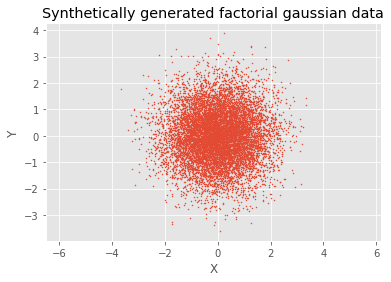

In [12]:
data_synthetic = rng.randn(data.shape[0], data.shape[1])

fig, ax = plt.subplots()
ax.scatter(data_synthetic[:, 0], data_synthetic[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Synthetically generated factorial gaussian data')
ax.axis('equal')
plt.show()

### Synthesize New Data from RBIG Model

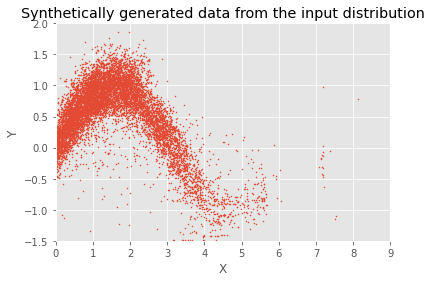

In [13]:
data_original_synthetic = rbig_model.inverse_transform(data_synthetic)

fig, ax = plt.subplots()
ax.scatter(data_original_synthetic[:, 0], data_original_synthetic[:, 1], s=1)
# ax.scatter(data[:, 0], data[:, 1], s=1)

ax.set_ylim([-1.5, 2.0])
ax.set_xlim([0.0, 9.0])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Synthetically generated data from the input distribution')
plt.show()

### Estimating Probabilities with RBIG

In [14]:
%%time
prob_input = rbig_model.predict_proba(data)

#print(f"Prob Input Domain - min: {prob_input.min():.3e}, max: {prob_input.max():.3e}")
#print(f"Prob Gauss Domain - min: {prob_gauss.min():.3e}, max: {prob_gauss.max():.3e}")
#print(f"Det:: {rbig_model.det_jacobians:.3e}")

CPU times: user 295 ms, sys: 0 ns, total: 295 ms
Wall time: 296 ms


### Original Data with Probabilities

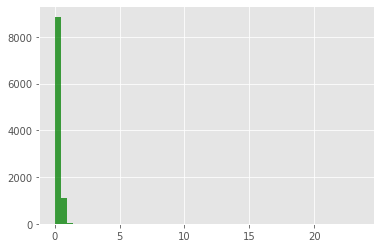

In [15]:
fig, ax = plt.subplots()
ax.hist(np.log(prob_input+1), 50, facecolor='green', alpha=0.75)
plt.show()

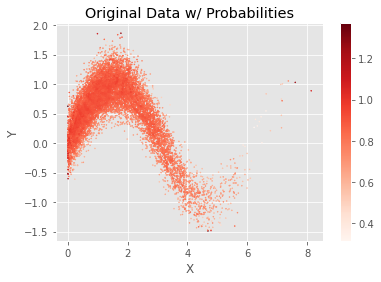

In [16]:
fig, ax = plt.subplots()

h = ax.scatter(data[:, 0], data[:, 1], s=1, c=np.log(prob_input+1)**0.1, cmap='Reds')
#h = ax.scatter(data[:, 0], data[:, 1], s=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
cbar = plt.colorbar(h, )
ax.set_title('Original Data w/ Probabilities')
plt.show()